In [1]:
import os
import time
import datetime

import numpy as np

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

import pathlib
import PIL
from IPython import display

In [2]:
# Определение дата сета
_URL = 'https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets/facades.tar.gz'

path_to_zip = tf.keras.utils.get_file('facades.tar.gz',
                                      origin=_URL,
                                      extract=True)

data_path = os.path.join(os.path.dirname(path_to_zip), 'facades/')

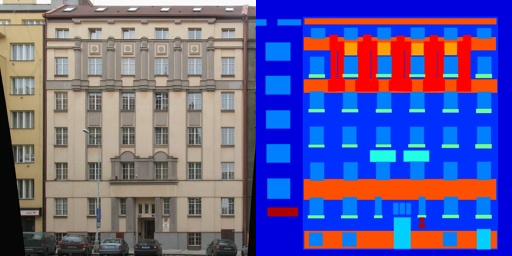

In [3]:
# Демонстрация входных данных
data_dir = tf.keras.utils.get_file('facades',
                                      origin=_URL,
                                      untar=True)
data_dir = pathlib.Path(data_dir)
test_data = list(data_dir.glob('test/*'))
PIL.Image.open(str(test_data[0]))

In [4]:
BUFFER_SIZE = 400
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [5]:
# Загрузка входного изображения и разбиение его на целевое и входное
def load(image_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image)

    w = tf.shape(image)[1]

    w = w // 2
    real_image = image[:, :w, :]
    input_image = image[:, w:, :]

    input_image = tf.cast(input_image, tf.float32)
    real_image = tf.cast(real_image, tf.float32)
    
    return input_image, real_image

In [6]:
# Увеличиваем изображение до 286 х 286 пикселей
def resize(input_image, real_image, height, width):
    input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    return input_image, real_image

In [7]:
# Слечайным образом обрезаем до 256 х 256
def random_crop(input_image, real_image):
    stacked_image = tf.stack([input_image, real_image], axis=0)
    cropped_image = tf.image.random_crop(stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

    return cropped_image[0], cropped_image[1]

In [8]:
# Случайным образом преобразуем изображение (вырезая чать, отзеркаливая). Необходимо для лучшего обучения
@tf.function()
def random_jitter(input_image, real_image):
    input_image, real_image = resize(input_image, real_image, 286, 286)

    input_image, real_image = random_crop(input_image, real_image)

    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        real_image = tf.image.flip_left_right(real_image)

    return input_image, real_image

In [9]:
# Нормализуем изображение к [-1, 1]
def normalize(input_image, real_image):
    input_image = (input_image / 127.5) - 1
    real_image = (real_image / 127.5) - 1

    return input_image, real_image

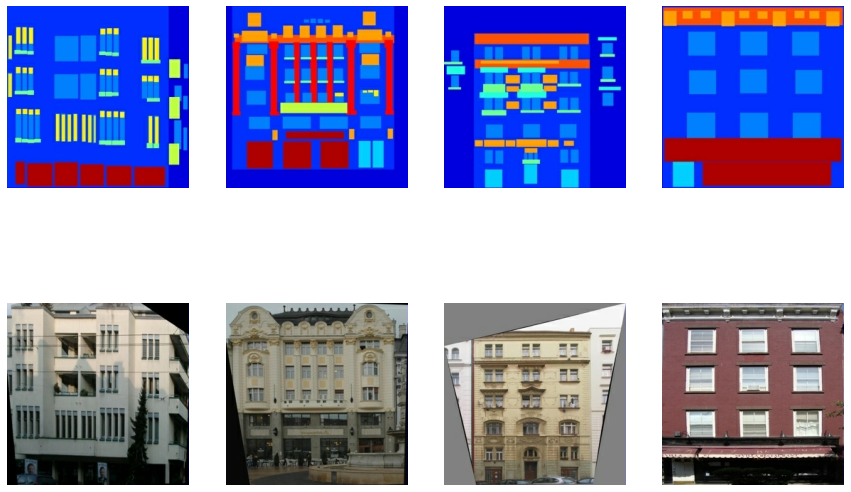

In [10]:
plt.figure(figsize=(15,10))
for i in range(4):
    inp, res = load(data_path + f'train/{i+1}.jpg')
    inp, res = normalize(inp, res)
    plt.subplot(2, 4, i + 1)
    plt.imshow(inp * 0.5 + 0.5)
    plt.axis('off')
    plt.subplot(2, 4, i + 5)
    plt.imshow(res * 0.5 + 0.5)
    plt.axis('off')
    
plt.show()

In [11]:
# Загрузка всех тренирующих
def load_image_train(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = random_jitter(input_image, real_image)
    input_image, real_image = normalize(input_image, real_image)

    return input_image, real_image

In [12]:
# Загрузка всех тестирующих
def load_image_test(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = resize(input_image, real_image,
                                   IMG_HEIGHT, IMG_WIDTH)
    input_image, real_image = normalize(input_image, real_image)

    return input_image, real_image

In [13]:
train_dataset = tf.data.Dataset.list_files(data_path+'train/*.jpg')
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [14]:
test_dataset = tf.data.Dataset.list_files(data_path+'test/*.jpg')
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [15]:
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.LeakyReLU())

    return result

In [16]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

    result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result

In [17]:
# Генератор основанный на принципе U-net
def Generator():
    inputs = tf.keras.layers.Input(shape=[256, 256, 3])

    down_stack = [
        downsample(64, 4, apply_batchnorm=False),  # (bs, 128, 128, 64)
        downsample(128, 4),  # (bs, 64, 64, 128)
        downsample(256, 4),  # (bs, 32, 32, 256)
        downsample(512, 4),  # (bs, 16, 16, 512)
        downsample(512, 4),  # (bs, 8, 8, 512)
        downsample(512, 4),  # (bs, 4, 4, 512)
        downsample(512, 4),  # (bs, 2, 2, 512)
        downsample(512, 4),  # (bs, 1, 1, 512)
      ]

    up_stack = [
        upsample(512, 4, apply_dropout=True),  # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True),  # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True),  # (bs, 8, 8, 1024)
        upsample(512, 4),  # (bs, 16, 16, 1024)
        upsample(256, 4),  # (bs, 32, 32, 512)
        upsample(128, 4),  # (bs, 64, 64, 256)
        upsample(64, 4),  # (bs, 128, 128, 128)
    ]

    last = tf.keras.layers.Conv2DTranspose(3, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=tf.random_normal_initializer(0., 0.2),
                                         activation='tanh')  # (bs, 256, 256, 3)

    x = inputs

    # Последовательное уменьшение входных данных
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Повышение дискредитации
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [18]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
    tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

    x = tf.keras.layers.concatenate([inp, tar])  # (bs, 256, 256, channels*2)

    down1 = downsample(64, 4, False)(x)  # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1)  # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2)  # (bs, 32, 32, 256)

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (bs, 34, 34, 256)
    conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (bs, 31, 31, 512)

    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (bs, 33, 33, 512)

    last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=[inp, tar], outputs=last)

In [19]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# Потеря генератора (Сгенерированное изображение и массив единиц)
def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

    # Средняя абсолютная ошибка
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

    total_gen_loss = gan_loss + (100 * l1_loss)

    return total_gen_loss, gan_loss, l1_loss

In [20]:
# Потеря дискриминатора
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss

In [21]:
# Оптимизаторы
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [22]:
generator = Generator()
discriminator = Discriminator()

In [23]:
# Настройка чекпоинтов
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [24]:
# Вывод картинок для отслеживания тестирования
def generate_images(model, test_input, tar):
    prediction = model(test_input, training=True)
    plt.figure(figsize=(15, 15))

    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])

        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

In [25]:
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [26]:
@tf.function
def train_step(input_image, target, epoch):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)

        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)

        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(gen_total_loss, generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))

    with summary_writer.as_default():
        tf.summary.scalar('gen_total_loss', gen_total_loss, step=epoch)
        tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=epoch)
        tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=epoch)
        tf.summary.scalar('disc_loss', disc_loss, step=epoch)

In [27]:
def fit(train_ds, epochs, test_ds):
    for epoch in range(epochs):
        start = time.time()

        display.clear_output(wait=True)

        for example_input, example_target in test_ds.take(1):
            generate_images(generator, example_input, example_target)
        print("Epoch: ", epoch)

        # Обучение
        for n, (input_image, target) in train_ds.enumerate():
            print('.', end='')
            if (n+1) % 100 == 0:
                print()
            train_step(input_image, target, epoch)
        print()

        # Сохраняем чекпоинт каждые 10 эпох
        if (epoch + 1) % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1, time.time()-start))
    checkpoint.save(file_prefix=checkpoint_prefix)

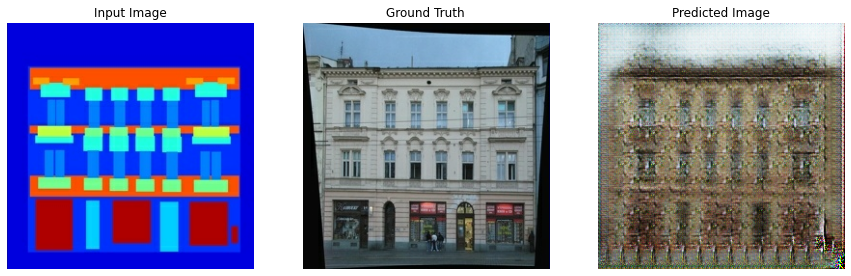

Epoch:  49
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................

Time taken for epoch 50 is 191.75812816619873 sec



In [28]:
fit(train_dataset, 50, test_dataset)

In [28]:
%load_ext tensorboard
%tensorboard --logdir {log_dir}

Reusing TensorBoard on port 6006 (pid 207), started 2:16:50 ago. (Use '!kill 207' to kill it.)

In [29]:
ls {checkpoint_dir}

checkpoint*                  ckpt-4.data-00000-of-00001*
ckpt-1.data-00000-of-00001*  ckpt-4.index*
ckpt-1.index*                ckpt-5.data-00000-of-00001*
ckpt-2.data-00000-of-00001*  ckpt-5.index*
ckpt-2.index*                ckpt-6.data-00000-of-00001*
ckpt-3.data-00000-of-00001*  ckpt-6.index*
ckpt-3.index*


In [30]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [31]:
def test_res(input_im, target_im):
    gen_output = generator(input_im, training=True)
    plt.figure(figsize=(15, 15))

    display_list = [input_im[0], target_im[0], gen_output[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])

        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()    

    disc_real_output = discriminator([input_im, target_im], training=True)
    disc_generated_output = discriminator([input_im, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target_im)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)
    
    print(f'Ошибка генератор: {gen_l1_loss.numpy()}\t\t Ошибка дискриминатора: {disc_loss.numpy()}')

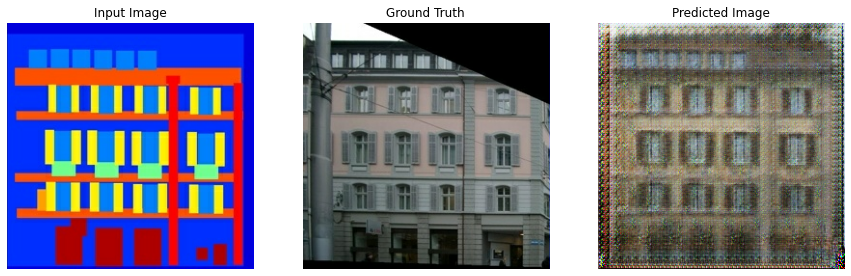

Ошибка генератор: 0.3638927638530731		 Ошибка дискриминатора: 0.0023876912891864777


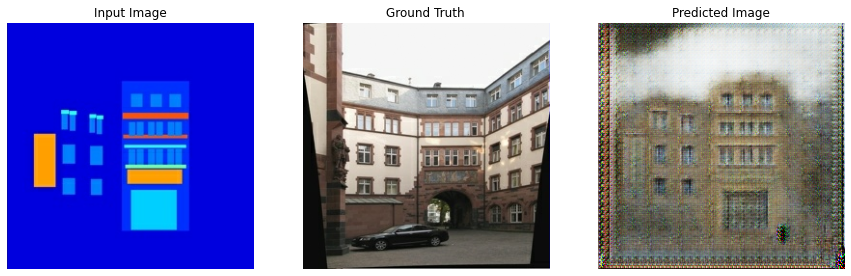

Ошибка генератор: 0.42489203810691833		 Ошибка дискриминатора: 0.0020615498069673777


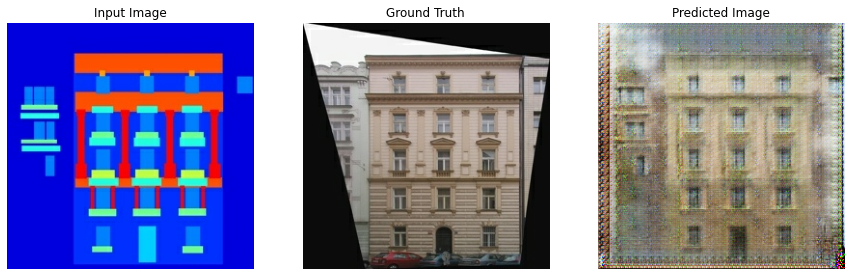

Ошибка генератор: 0.4337116777896881		 Ошибка дискриминатора: 0.001490960014052689


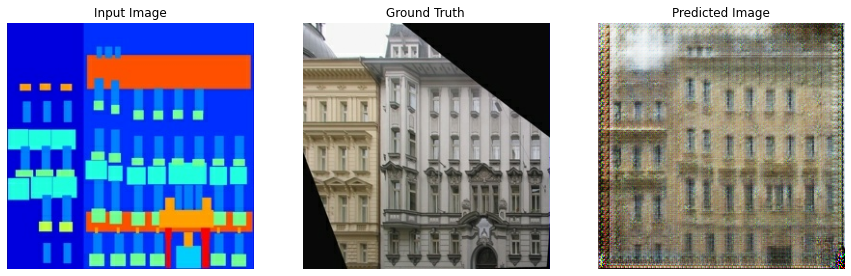

Ошибка генератор: 0.37172242999076843		 Ошибка дискриминатора: 0.0022083234507590532


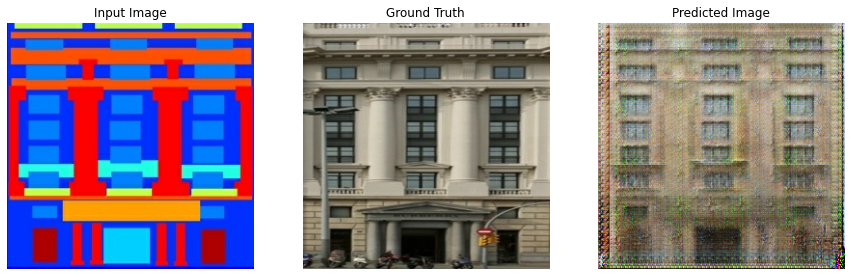

Ошибка генератор: 0.3390531539916992		 Ошибка дискриминатора: 0.00359256356023252


In [32]:
for inp, tar in test_dataset.take(5):
    test_res(inp, tar)

In [33]:
def worst_gen(data, worst_num):
    l1_losses = []
    images = []
    for n, (input_image, target) in data.enumerate():
        gen_output = generator(input_image, training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)
        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
        
        l1_losses.append(gen_l1_loss.numpy())
        images.append([input_image[0], target[0], gen_output[0]])
    l1_loss = l1_losses.copy()
    l1_loss = sorted(l1_loss)
    for val in sorted(l1_loss)[len(l1_loss)-worst_num:]:
        i = 0
        for val2 in l1_losses:
            if val == val2:
                plt.figure(figsize=(15, 15))
                title = ['Input Image', 'Ground Truth', 'Predicted Image']
                for j in range(3):
                    plt.subplot(1, 3, j+1)
                    plt.title(title[j])
                    
                    plt.imshow(images[i][j] * 0.5 + 0.5)
                    plt.axis('off')
                plt.show()
                print(f'Ошибка генератор: {val2}')
            i += 1

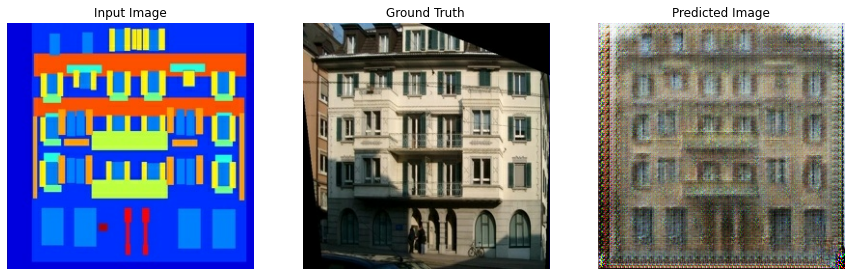

Ошибка генератор: 0.4914722144603729


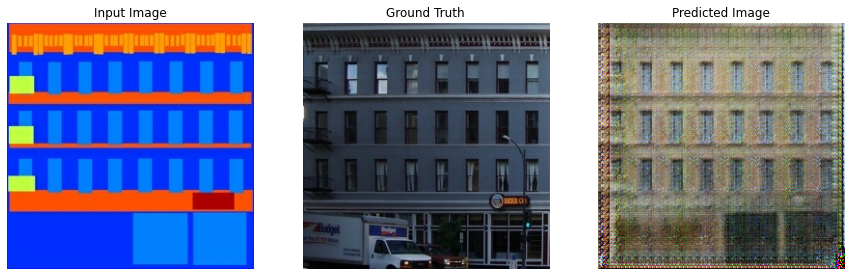

Ошибка генератор: 0.49175095558166504


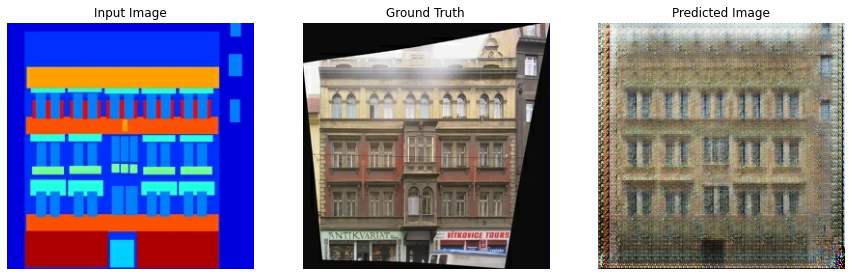

Ошибка генератор: 0.4977322816848755


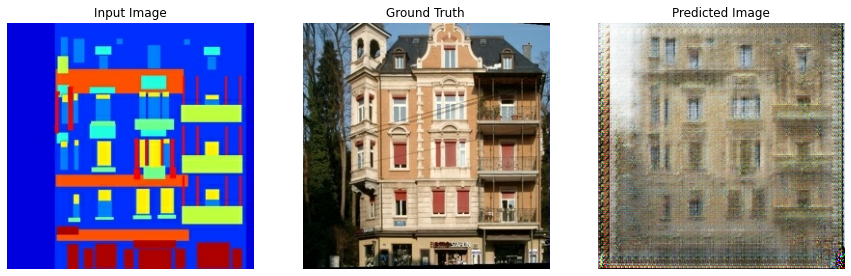

Ошибка генератор: 0.5060827732086182


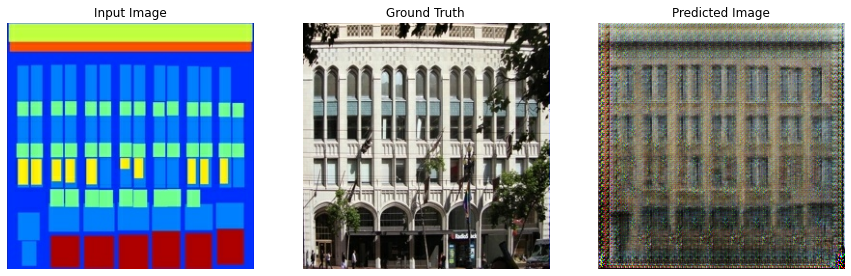

Ошибка генератор: 0.5072701573371887


In [34]:
worst_gen(test_dataset, 5)

In [35]:
def try_pic(pic):
    new_test_data = tf.data.Dataset.list_files(data_path+f'val/{pic}')
    new_test_data = new_test_data.map(load_image_test)
    new_test_data = new_test_data.batch(BATCH_SIZE)

    for inp, tar in new_test_data.take(1):
        test_res(inp, tar)

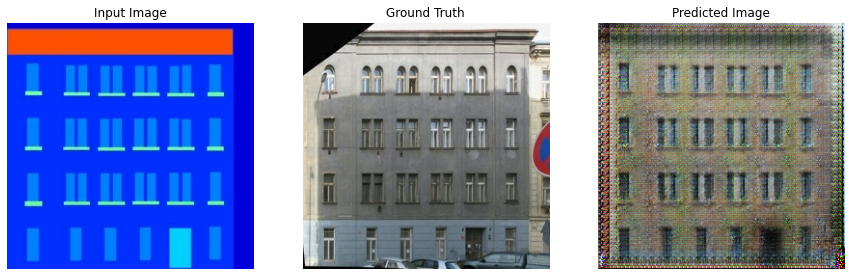

Ошибка генератор: 0.3306269645690918		 Ошибка дискриминатора: 0.0031428092624992132


In [36]:
try_pic('59.jpg')